<a href="https://colab.research.google.com/github/abhisheksuran/Atari_DQN/blob/master/PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
sys.path.append('../Simulator')

from motoflex_gym import WalkingSimulator
from motoflex_gym.gym_world import MoToFlexEnv
import numpy as np
import gymnasium as gym
import PIL
from IPython import display
import csv

https://www.gymlibrary.dev/environments/classic_control/cart_pole/

https://en.wikipedia.org/wiki/Proximal_Policy_Optimization

https://www.gymlibrary.dev/content/environment_creation/

First, we define observations and the reward function. Reward will be summed up from this terms. These are specific to the action space, e.g. you always want to provide the last action, the current coords etc. In the following first example our action will the joint angles, thus we would like to provide the current angles.

Afterwards we execute an example by using prerecorded angles. So setting up an RL environment with observations etc. is not neccessary, but we do it so debugging purposes.

Here we use the definition in nao.h, make sure
it matches your robot. The angle array contains:
lHipRoll, lHipPitch, lKneePitch, lAnklePitch, 
lAnkleRoll, rHipRoll, rHipPitch, rKneePitch, 
rAnklePitch, rAnkleRoll
Limits:

```css
lHipRoll = {offset = 0deg; minAngle = -21.74deg; maxAngle = 45.29deg;};
lHipPitch = {offset = 0deg; minAngle = -88deg; maxAngle = 27.73deg;};
lKneePitch = {offset = 0deg; minAngle = -5.29deg; maxAngle = 121.04deg;};
lAnklePitch = {offset = 0deg; minAngle = -68.15deg; maxAngle = 52.86deg;};
lAnkleRoll = {offset = 0deg; minAngle = -22.79deg; maxAngle = 44.06deg;};
 
rHipRoll = {offset = 0deg; minAngle = -45.29deg; maxAngle = 21.74deg;};
rHipPitch = {offset = 0deg; minAngle = -88deg; maxAngle = 27.73deg;};
rKneePitch = {offset = 0deg; minAngle = -5.9deg; maxAngle = 121.47deg;};
rAnklePitch = {offset = 0deg; minAngle = -67.97deg; maxAngle = 53.4deg;};
rAnkleRoll = {offset = 0deg; minAngle = -44.06deg; maxAngle = 22.8deg;};  
```

Using this, we start we the definition of the joint limits.

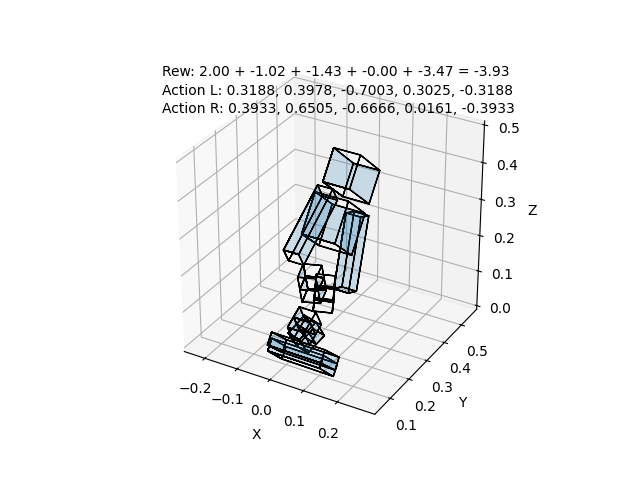

Sim returned  False False


In [2]:
nao_joints = gym.spaces.Box(
    np.array([-0.38, -1.56, -0.09, -1.19, -0.4, -0.79, -1.56, -0.09, -1.19, -0.77]),
    np.array([0.79, 0.48, 2.11, 0.92, 0.77, 0.38, 0.48, 2.12, 0.93, 0.4]),
    dtype=float
    )
obs_space = gym.spaces.Dict({
        # Pos could be useless as it is currently a global position
        "current_body_pos": gym.spaces.Box(-np.inf, np.inf, shape=(3,), dtype=float),

        # Vel useful because the error between desired and actual
        # is what will need forces/torques and indicates a fall-down,
        "current_lin_vel": gym.spaces.Box(-np.inf, np.inf, shape=(3,), dtype=float),

        # Required to keep the body upright
        "current_body_orientation": gym.spaces.Box(-1.57, 1.57, shape=(3,), dtype=float),

        # Good sensors and it could be the source for vel errors,
        # additionally RL should know the current angle to find
        # the appropiate next desired angle
        "current_angles": nao_joints,

        # So RL knows what we want to do
        "target_com_pos": gym.spaces.Box(-np.inf, np.inf, shape=(3,), dtype=float),
        "target_lin_vel": gym.spaces.Box(-np.inf, np.inf, shape=(3,), dtype=float),
})

obs_terms = lambda: {
    "current_body_pos": np.array(WalkingSimulator.get_6d_pose()[:3]),
    "current_lin_vel": np.array(WalkingSimulator.get_velocity()),
    "current_angles": WalkingSimulator.get_joint_angles(),
    "current_body_orientation": np.array(WalkingSimulator.get_6d_pose()[3:]),
    "target_com_pos": np.array([0, 0, 0.34], dtype='float64'),
    "target_lin_vel": np.array([0, 0, 0], dtype='float64')
    }

rew_terms = [ 
    lambda _, __: 2,
    lambda obs, _: - 20 * np.sum(np.abs(obs["current_body_pos"][2] - obs["target_com_pos"][2])),
    lambda obs, _: - 1 * np.sum(np.abs(obs['current_lin_vel'] - obs['target_lin_vel'])),
    lambda obs, last_action: - 0.1 * np.sum(np.abs(last_action)),
    lambda obs, _: - 5 * np.sum(np.abs(obs['current_body_orientation'][:2]))
]

action_space = nao_joints

action_function = lambda d, _: (d, [0.] * 10)

env = gym.make("MoToFlex/WalkingSimulator-v0", 
               render_mode='rgb_array', 
               observation_space = obs_space,
               observation_terms = obs_terms,
               reward_functions = rew_terms,
               action_space = action_space,
               action_function = action_function,
               ab_filter_alpha = 0)
done = False
truncated = False
state, _ = env.reset()

csvfile = open('config/UncompensatedTarget.csv', newline='')
csv_angles = csv.reader(csvfile, delimiter=';')
next(csv_angles)
next(csv_angles)  # No real reason for this, but this matches the non-python mode

for row in csv_angles:
    observation, reward, terminated, truncated, _ = env.step(list(np.array(row).astype('float') * [1, -1, -1, -1, 1, -1, -1, -1, -1, -1]))
    if terminated or truncated:
        print("Sim returned ", done, truncated)
        break
    
    state = observation
    
    display.clear_output(wait=True)
    img = env.render()
    img = PIL.Image.fromarray(img)
    display.display(img)  

csvfile.close()

Now we want to use polar coordinates. Thus, observationd and action space and terms will change. We also add random pushes so the task will not be that easy.

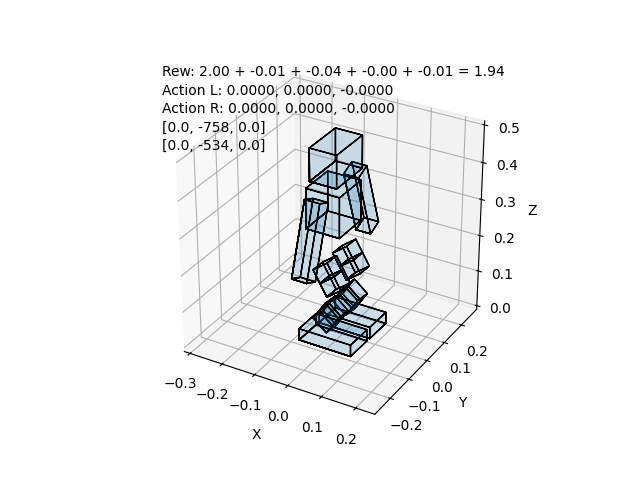

In [3]:
# Here we just go down an stand
obs_space = gym.spaces.Dict({
        # Pos could be useless as it is currently a global position
        "current_body_pos": gym.spaces.Box(-np.inf, np.inf, shape=(3,), dtype=float),

        # Vel useful because the error between desired and actual
        # is what will need forces/torques and indicates a fall-down,
        "current_lin_vel": gym.spaces.Box(-np.inf, np.inf, shape=(3,), dtype=float),

        # Required to keep the body upright
        "current_body_orientation": gym.spaces.Box(-1.57, 1.57, shape=(3,), dtype=float),

        # Good sensors and it could be the source for vel errors,
        # additionally RL should know the current angle to find
        # the appropiate next desired angle
        "current_polar_coords": gym.spaces.Box(-np.inf, np.inf, shape=(6,), dtype=float),

        # So RL knows what we want to do
        "target_com_pos": gym.spaces.Box(-np.inf, np.inf, shape=(3,), dtype=float),
        "target_lin_vel": gym.spaces.Box(-np.inf, np.inf, shape=(3,), dtype=float),
})

obs_terms = lambda: {
    "current_body_pos": np.array(WalkingSimulator.get_6d_pose()[:3]),
    "current_lin_vel": np.array(WalkingSimulator.get_velocity()),
    "current_polar_coords": MoToFlexEnv.current_polar_pos(),
    "current_body_orientation": np.array(WalkingSimulator.get_6d_pose()[3:]),
    "target_com_pos": np.array([0, 0, 0.34], dtype='float64'),
    "target_lin_vel": np.array([0, 0, 0], dtype='float64')
    }

rew_terms = [ 
    lambda _, __: 2,
    lambda obs, _: - 20 * np.sum(np.abs(obs["current_body_pos"][2] - obs["target_com_pos"][2])),
    lambda obs, _: - 1 * np.sum(np.abs(obs['current_lin_vel'] - obs['target_lin_vel'])),
    lambda _, last_action: - 0.1 * np.sum(np.abs(last_action)),
    lambda obs, _: - 5 * np.sum(np.abs(obs['current_body_orientation'][:2]))
]

action_space = gym.spaces.Box(-10, 10, shape=(6,), dtype=float)

action_function = lambda d, env: (env.delta_polar_to_angles(*d / 100), d.tolist())

env = gym.make("MoToFlex/WalkingSimulator-v0", 
               render_mode='rgb_array', 
               observation_space = obs_space,
               observation_terms = obs_terms,
               reward_functions = rew_terms,
               action_space = action_space,
               action_function = action_function,
               ab_filter_alpha = 0.1,
               random_push = {
                       "probability": 0.01, 
                       "force_range_y": [500, 1000]
                }
        )
done = False
truncated = False
state, _ = env.reset()

for _ in range(37):
        env.step(np.array([0, 0, -0.1, 0, 0, -0.1]))
        img = env.render()
        display.clear_output(wait=True)
        img = PIL.Image.fromarray(img)
        display.display(img)  

for _ in range(100):
        env.step(np.array([0, 0, -0., 0, 0, -0.]))
        display.clear_output(wait=True)
        img = env.render()
        img = PIL.Image.fromarray(img)
        display.display(img)  
        

Further possible actions:

```python
        if self.action_type == 'delta_angles':
            delta_action = data.tolist()
            action = [a / 5 + b for a, b in zip(delta_action, WalkingSimulator.get_joint_angles())]
        elif self.action_type == 'absolute_angles':
            delta_action = [0] * 10
            action = data
        elif self.action_type == 'delta_cart':
            raise Exception("Unimplemented")
        elif self.action_type == 'delta_polar':
            delta_action = data.tolist()
            action = self.delta_polar_to_angles(*data / 100)
        else:
            raise Exception("Unknown data type")
```


Actions spaces:

```python

delta_angle_action_space = spaces.Box(-0.7, 0.7, shape=(10,), dtype=float)
absolute_angles_action_space = nao_joint_defs
length_angle_delta = spaces.Box(-10, 10, shape=(6,), dtype=float)
```